In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import  layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding,Dot,Dense,Flatten,Input,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping
from tensorflow.keras.regularizers import l2

from wordcloud import WordCloud
%matplotlib inline

In [2]:
#### READING DATASET

In [3]:
import os

In [4]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [5]:
rating_df=pd.read_csv(INPUT_DIR+"/animelist.csv",low_memory=True, usecols=["user_id","anime_id","rating"],nrows=20_000_000)

In [6]:
rating_df

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10
...,...,...,...
19999995,64623,8247,0
19999996,64623,38810,0
19999997,64623,762,0
19999998,64623,41467,0


In [7]:
len(rating_df)

20000000

### DATA PROCESSING

In [8]:
n_rating=rating_df['user_id'].value_counts()
n_rating

user_id
20807    17546
63900    16774
50485    16639
11100    14429
22022    13696
         ...  
43381        1
29120        1
14789        1
17025        1
63541        1
Name: count, Length: 59561, dtype: int64

1. user_id - 11100 have rated 14429 anime (TAKE)
2. user_id - 10703 have rated 1 anime  (REMOVE)

In [9]:
valid_user_indices = n_rating[n_rating >= 400].index
rating_df = rating_df[rating_df["user_id"].isin(valid_user_indices)].copy()
# users with 400 or more rated anime is taken

In [10]:
rating_df

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0
...,...,...,...
19999995,64623,8247,0
19999996,64623,38810,0
19999997,64623,762,0
19999998,64623,41467,0


In [11]:
rating_df['rating'].value_counts()

rating
0     5818024
8     1776597
7     1738395
9     1074914
6      970601
10     697238
5      530667
4      246906
3      124723
2       72604
1       57123
Name: count, dtype: int64

In [12]:
min_rating=min(rating_df["rating"])
max_rating=max(rating_df["rating"])

In [13]:
avg_rating=np.mean(rating_df['rating'])
avg_rating

np.float64(4.048676695510578)

Scaling the rating which is ranging from 1-10 to 0-1 -> Min-Max scaling

In [14]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).astype(np.float64)

In [15]:
rating_df["rating"].value_counts()

rating
0.0    5818024
0.8    1776597
0.7    1738395
0.9    1074914
0.6     970601
1.0     697238
0.5     530667
0.4     246906
0.3     124723
0.2      72604
0.1      57123
Name: count, dtype: int64

In [16]:
avg_rating=np.mean(rating_df['rating'])
avg_rating

np.float64(0.40486766955105796)

In [17]:
rating_df.duplicated().sum()

np.int64(1)

In [18]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [19]:
user_ids = rating_df["user_id"].unique().tolist()

In [20]:
user_ids

[2,
 6,
 12,
 16,
 17,
 19,
 21,
 41,
 42,
 44,
 47,
 53,
 55,
 60,
 66,
 73,
 74,
 85,
 89,
 90,
 94,
 98,
 102,
 108,
 111,
 112,
 120,
 121,
 122,
 135,
 145,
 146,
 147,
 153,
 155,
 156,
 172,
 174,
 184,
 190,
 193,
 194,
 198,
 204,
 205,
 209,
 214,
 219,
 222,
 227,
 228,
 235,
 238,
 240,
 243,
 248,
 251,
 252,
 257,
 264,
 267,
 272,
 274,
 275,
 284,
 285,
 286,
 290,
 291,
 293,
 300,
 301,
 306,
 308,
 310,
 313,
 314,
 316,
 320,
 321,
 324,
 325,
 326,
 327,
 330,
 336,
 340,
 345,
 346,
 349,
 350,
 366,
 367,
 371,
 372,
 375,
 381,
 382,
 386,
 389,
 398,
 405,
 406,
 413,
 414,
 418,
 423,
 426,
 428,
 431,
 432,
 436,
 437,
 438,
 440,
 442,
 444,
 445,
 446,
 455,
 457,
 459,
 464,
 467,
 468,
 469,
 478,
 481,
 483,
 484,
 486,
 493,
 498,
 500,
 516,
 517,
 519,
 524,
 526,
 529,
 531,
 538,
 542,
 547,
 549,
 559,
 563,
 564,
 566,
 569,
 571,
 577,
 590,
 593,
 596,
 601,
 603,
 608,
 613,
 614,
 617,
 620,
 629,
 631,
 639,
 642,
 643,
 644,
 649,
 652,
 655

In [21]:
user2user_encoded = {ids: index for index , ids in enumerate(user_ids)}

In [22]:
user2user_encoded

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [23]:
user2user_decoded = {index: ids for index,ids in enumerate(user_ids)}

In [24]:
user2user_decoded

{0: 2,
 1: 6,
 2: 12,
 3: 16,
 4: 17,
 5: 19,
 6: 21,
 7: 41,
 8: 42,
 9: 44,
 10: 47,
 11: 53,
 12: 55,
 13: 60,
 14: 66,
 15: 73,
 16: 74,
 17: 85,
 18: 89,
 19: 90,
 20: 94,
 21: 98,
 22: 102,
 23: 108,
 24: 111,
 25: 112,
 26: 120,
 27: 121,
 28: 122,
 29: 135,
 30: 145,
 31: 146,
 32: 147,
 33: 153,
 34: 155,
 35: 156,
 36: 172,
 37: 174,
 38: 184,
 39: 190,
 40: 193,
 41: 194,
 42: 198,
 43: 204,
 44: 205,
 45: 209,
 46: 214,
 47: 219,
 48: 222,
 49: 227,
 50: 228,
 51: 235,
 52: 238,
 53: 240,
 54: 243,
 55: 248,
 56: 251,
 57: 252,
 58: 257,
 59: 264,
 60: 267,
 61: 272,
 62: 274,
 63: 275,
 64: 284,
 65: 285,
 66: 286,
 67: 290,
 68: 291,
 69: 293,
 70: 300,
 71: 301,
 72: 306,
 73: 308,
 74: 310,
 75: 313,
 76: 314,
 77: 316,
 78: 320,
 79: 321,
 80: 324,
 81: 325,
 82: 326,
 83: 327,
 84: 330,
 85: 336,
 86: 340,
 87: 345,
 88: 346,
 89: 349,
 90: 350,
 91: 366,
 92: 367,
 93: 371,
 94: 372,
 95: 375,
 96: 381,
 97: 382,
 98: 386,
 99: 389,
 100: 398,
 101: 405,
 102: 406,
 

In [25]:
### 11054 : 12 ---> user2user_encoded
### 12 : 11054 ---> user2user_decoded

In [26]:
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [27]:
rating_df

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0
...,...,...,...,...
19999995,64623,8247,0.0,16736
19999996,64623,38810,0.0,16736
19999997,64623,762,0.0,16736
19999998,64623,41467,0.0,16736


In [28]:
n_users = len(user2user_encoded)
n_users

16737

In [29]:
anime_ids=rating_df["anime_id"].unique().tolist()
anime2anime_encoded={ids:index for index,ids in enumerate(anime_ids)}
anime2anime_decoded={index:ids for index,ids in enumerate(anime_ids)}
rating_df["anime"]=rating_df["anime_id"].map(anime2anime_encoded)

In [30]:
rating_df

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4
...,...,...,...,...,...
19999995,64623,8247,0.0,16736,2840
19999996,64623,38810,0.0,16736,2899
19999997,64623,762,0.0,16736,2900
19999998,64623,41467,0.0,16736,3208


In [31]:
n_anime=len(anime2anime_encoded)
n_anime

17555

### Randomize Data so that model does not learn any pattern

In [32]:
rating_df=rating_df.sample(frac=1,random_state=43).reset_index(drop=True)
# frac=1 means 100% of the data

In [33]:
rating_df

,user_id,anime_id,rating,user,anime
0,37337,31798,0.8,9550,1067
1,28876,14349,0.8,7394,1919
2,40807,35968,0.0,10473,3414
3,45262,72,0.8,11643,579
4,18461,710,0.8,4703,3112
...,...,...,...,...,...
13107787,7516,16067,0.0,1898,1398
13107788,12682,28171,0.8,3208,67
13107789,29125,1829,0.0,7453,883
13107790,16703,25159,0.8,4257,1180


In [34]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [35]:
X

array([[ 9550,  1067],
       [ 7394,  1919],
       [10473,  3414],
       ...,
       [ 7453,   883],
       [ 4257,  1180],
       [ 9725,  2574]], shape=(13107792, 2))

In [36]:
test_size=1000
train_indices=rating_df.shape[0]-test_size

In [37]:
X_train,X_test,y_train,y_test=(
    X[:train_indices],
    X[train_indices :],
    y[:train_indices],
    y[train_indices :]
)

In [38]:
len(X_train),len(X_test)

(13106792, 1000)

In [39]:
type(X_train)

numpy.ndarray

In [40]:
X_train

array([[ 9550,  1067],
       [ 7394,  1919],
       [10473,  3414],
       ...,
       [12886,   525],
       [ 5475,  1931],
       [ 5650,  6200]], shape=(13106792, 2))

In [109]:
def get_datasets(X_train, y_train, X_test, y_test, batch_size=10000):
    train_ds = tf.data.Dataset.from_tensor_slices(
        ({"user": X_train[:, 0], "anime": X_train[:, 1]}, y_train)
    ).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_tensor_slices(
        ({"user": X_test[:, 0], "anime": X_test[:, 1]}, y_test)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds

In [ ]:
# import tensorflow as tf
# batch_size = 10000
# # Convert Train data to Dataset
# train_ds = tf.data.Dataset.from_tensor_slices(
#     (
#         {"user": X_train[:, 0], "anime": X_train[:, 1]},
#         y_train
#     )
# ).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# # Convert Test/Validation data to Dataset
# val_ds = tf.data.Dataset.from_tensor_slices(
#     (
#         {"user": X_test[:, 0], "anime": X_test[:, 1]},
#         y_test
#     )
# ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [110]:
train_ds,val_ds=get_datasets(X_train, y_train, X_test, y_test)

In [111]:
train_ds

<_PrefetchDataset element_spec=({'user': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'anime': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

### MODEL ARCHITECTURE

In [42]:
def RecommenderNet():
    embedding_size=32

    user = Input(name="user",shape=[1])

    user_embedding = Embedding(name="user_embedding",input_dim=n_users,output_dim=embedding_size,embeddings_regularizer=l2(1e-6))(user)

    anime = Input(name="anime",shape=[1])

    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size,embeddings_regularizer=l2(1e-6))(anime)

    x = Dot(name="dot_product",normalize=True,axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)
    x = Dense(32,activation="relu",kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation='linear')(x)

    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="mse",metrics=["mae","mse"],optimizer=Adam(learning_rate=1e-3))

    return model



In [43]:
model=RecommenderNet()

In [44]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 32)     │    535,584 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 32)     │    561,760 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │         64 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,097,441 (4.19 MB)

 Trainable params: 1,097,441 (4.19 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
start_lr = 0.00001 # lr = learning_rate
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch): # gives the best epoch for our model
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch+start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr)*exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [46]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=2,monitor="val_loss",mode="min",restore_best_weights=True)

In [47]:
my_callbacks=[model_checkpoint,lr_callback,early_stopping]

In [48]:
history = model.fit(
    train_ds,           # This replaces x=X_train_array and y=y_train
    validation_data=val_ds, # This replaces validation_data=(X_test_array, y_test)
    epochs=20,
    verbose=1,
    callbacks=my_callbacks
)

Epoch 1/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 76s 56ms/step - loss: 0.2973 - mae: 0.4113 - mse: 0.2962 - val_loss: 0.2850 - val_mae: 0.4104 - val_mse: 0.2839 - learning_rate: 1.0000e-05
Epoch 2/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 66s 50ms/step - loss: 0.2449 - mae: 0.3948 - mse: 0.2438 - val_loss: 0.2222 - val_mae: 0.3961 - val_mse: 0.2210 - learning_rate: 1.8000e-05
Epoch 3/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 61s 47ms/step - loss: 0.1905 - mae: 0.3818 - mse: 0.1894 - val_loss: 0.1681 - val_mae: 0.3797 - val_mse: 0.1670 - learning_rate: 2.6000e-05
Epoch 4/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 61s 46ms/step - loss: 0.1618 - mae: 0.3718 - mse: 0.1607 - val_loss: 0.1513 - val_mae: 0.3704 - val_mse: 0.1502 - learning_rate: 3.4000e-05
Epoch 5/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 59s 45ms/step - loss: 0.1573 - mae: 0.3690 - mse: 0.1562 - val_loss: 0.1503 - val_mae: 0.3693 - val_mse: 0.1492 - learning_rate: 4.2000e-05
Epoch 6/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 59s 45ms/step - loss: 0.1556 - mae: 0.3684 - mse

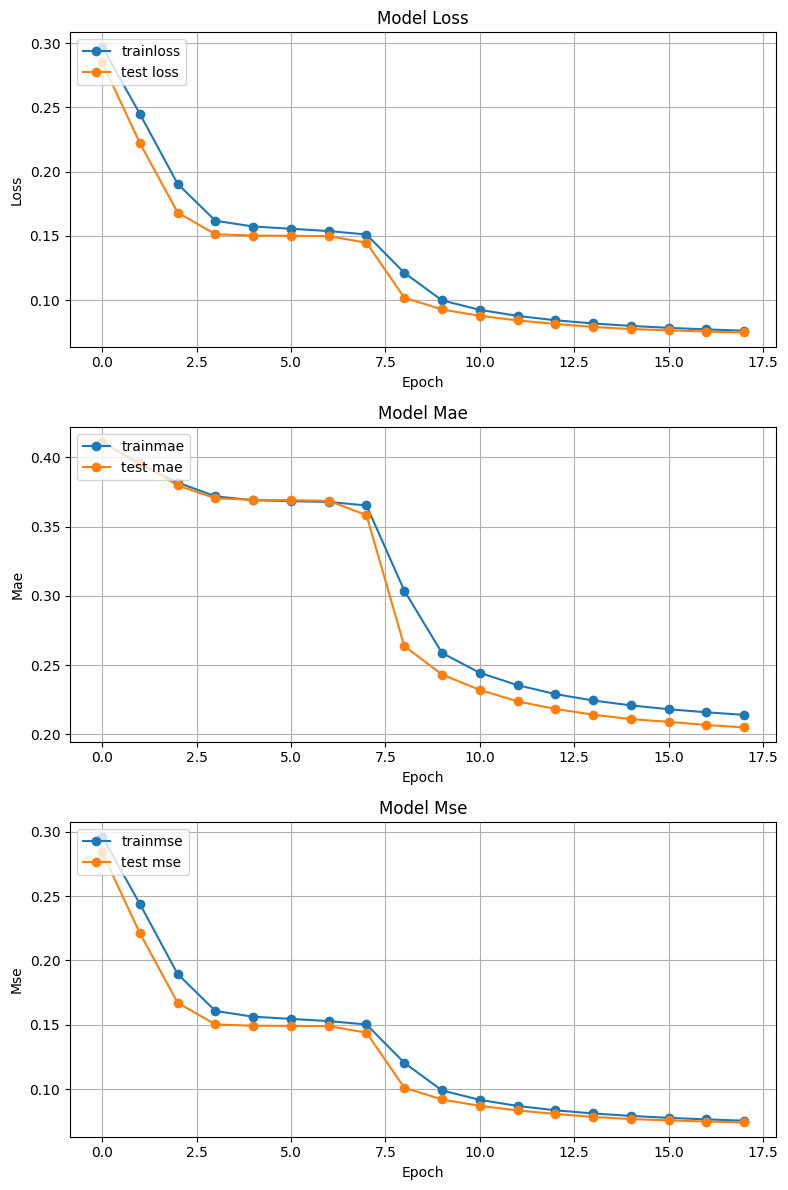

In [49]:
metrics = ["loss","mae","mse"]

fig,axes=plt.subplots(len(metrics),1,figsize=(8,len(metrics)*4))

for i,metrics in enumerate(metrics):
    ax=axes[i]
    ax.plot(history.history[metrics][0:-2],marker="o",label=f"train{metrics}")
    ax.plot(history.history[f"val_{metrics}"][0:-2],marker="o",label=f"test {metrics}")
    ax.set_title(f"Model {metrics.capitalize()}")
    ax.set_ylabel(metrics.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [50]:
def extract_weights(name,model):
    weight_layer=model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [51]:
anime_weights = extract_weights("anime_embedding",model)

In [52]:
user_weights = extract_weights("user_embedding",model)


In [53]:
anime_weights

array([[ 0.1351388 , -0.212129  , -0.05559196, ...,  0.29407686,
        -0.2295233 ,  0.16940993],
       [ 0.21535124, -0.18031713, -0.07900599, ..., -0.4757779 ,
        -0.15036291,  0.08995259],
       [-0.07965163, -0.10020495, -0.44776827, ..., -0.09598236,
        -0.0813981 ,  0.43932608],
       ...,
       [-0.19870917,  0.05646299, -0.22362532, ..., -0.14888898,
        -0.25309935, -0.04560399],
       [ 0.20714314,  0.17368439,  0.463739  , ..., -0.09575203,
         0.18613987,  0.00770294],
       [-0.06958411, -0.09999571,  0.0690897 , ..., -0.16362847,
         0.16965903,  0.11474317]], shape=(17555, 32), dtype=float32)

## READING ANIME.CSV

In [54]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [55]:
df=df.replace("Unknown",np.nan)

In [56]:
df.isnull().sum()

MAL_ID               0
Name                 0
Score             5141
Genres              63
English name     10565
Japanese name       48
Type                37
Episodes           516
Aired              309
Premiered        12817
Producers         7794
Licensors        13616
Studios           7079
Source            3567
Duration           555
Rating             688
Ranked            1762
Popularity           0
Members              0
Favorites            0
Watching             0
Completed            0
On-Hold              0
Dropped              0
Plan to Watch        0
Score-10           437
Score-9           3167
Score-8           1371
Score-7            503
Score-6            511
Score-5            584
Score-4            977
Score-3           1307
Score-2           1597
Score-1            459
dtype: int64

In [57]:
def getAnimeName(anime_id):
    try:
        name=df[df['anime_id'] == anime_id]['eng_version'].values[0]
        if name is np.nan:
            name = df[df['anime_id'] == anime_id]['Name'].values[0]
    except:
        print("Error")
    return name

In [58]:
df["anime_id"]=df["MAL_ID"]
df["eng_version"]=df["English name"]
df["eng_version"]=df['anime_id'].apply(lambda x: getAnimeName(x))

In [59]:
getAnimeName(6702)

'Fairy Tail'

In [60]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [61]:
df.sort_values(by=["Score"],inplace=True,ascending=False,kind="quicksort",na_position="last")

In [62]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [63]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [64]:
df=df[["anime_id","eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [65]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [66]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df['anime_id']==anime]
    if isinstance(anime,str):
        return df[df['eng_version']==anime]

In [67]:
getAnimeFrame('Fullmetal Alchemist:Brotherhood',df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456


# ANIME_WITH_SYNOPSIS.CSV

In [68]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [69]:
synopsis_df=pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

In [70]:
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [ ]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df["MAL_ID"]==anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df["Name"]==anime].sypnopsis.values[0]

In [72]:
getSynopsis(8,synopsis_df)

"It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon Squad is known to be the strongest busters on the continent. A young boy, Beet, dreams of joining the Zenon Squad. However, one day, as a result of Beet's fault, the Zenon squad was defeated by the devil, Beltose. The five dying busters sacrificed their life power into their five weapons, Saiga. After giving their weapons to Beet, they passed away. Years have passed since then and the young Vandel Buster, Beet, begins his adventure to carry out the Zenon Squad's will to put an end to the dark century."

In [73]:
getSynopsis("Witch Hunter Robin",synopsis_df)

"ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"

## CONTENT/ITEM BASED RECOMMENDATION

In [74]:
# Whole df gets displayed

pd.set_option("max_colwidth",None)

In [75]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


In [76]:
getAnimeFrame(40028,df)['anime_id'].values[0]

np.int64(40028)

# REAL

In [ ]:
# def find_similar_animes(name,anime_weights,anime2anime_encoded,anime2anime_decoded,df,synopsis_df,n=10,return_dist=False,neg=False):
#                         #n is how many recommendations do you want
#                         #neg=True it will find the most dissimilar animes
#     try:
        
#         index=getAnimeFrame(name,df).anime_id.values[0]
#         encoded_index=anime2anime_encoded.get(index)

#         weights=anime_weights
#         weights = np.squeeze(anime_weights)

#         dists=np.dot(weights,weights[encoded_index])
#         sorted_dists=np.argsort(dists) # np.argsort sorts the indices from the lowest value to the highest value

#         #The start of the sorted array contains the indices of the most dissimilar anime (lowest scores).

#         # The end of the sorted array contains the indices of the most similar anime (highest scores).

#         n=n+1 # to include target anime itself

#         if neg:# Fetch dissimilar anime
#             closest = sorted_dists[:n]
#         else:
#             closest = sorted_dists[-n:]


#         if return_dist:
#             return dists,closest

#         SimilarityArr = []

#         for close in closest:
#             decoded_id = anime2anime_decoded.get(close)


#             anime_frame=getAnimeFrame(decoded_id,df)

#             anime_name=anime_frame.eng_version.values[0]
#             genre=anime_frame.Genres.values[0]
#             similarity=dists[close]

#             SimilarityArr.append({
#                 "anime_id":decoded_id,
#                 "name":anime_name,
#                 "similarity":similarity,
#                 "genre":genre,
#             })

#         Frame=pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
#         return Frame[Frame.anime_id!=index].drop(['anime_id'],axis=1) # dropping the input

#     except Exception as e:
#         print("Error Occured",e)


In [100]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    try:
        # 1. Get the correct index
        anime_info = getAnimeFrame(name, df)
        if anime_info.empty:
            return None
            
        index = anime_info.anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        # 2. Ensure weights are 2D (Rows x Features)
        weights = np.squeeze(anime_weights)
        target_vector = weights[encoded_index].reshape(-1) 
        
        # 3. Vectorized Similarity Calculation
        # weights: (17555, 32), weights[encoded_index]: (32,)
        dists = np.dot(weights, target_vector)
        
        # 4. Sorting logic
        sorted_dists = np.argsort(dists)
        n_plus = n + 1 

        if neg:
            closest = sorted_dists[:n_plus]
        else:
            closest = sorted_dists[-n_plus:]

        if return_dist:
            return dists, closest

        # 5. Build Result List
        SimilarityArr = []
        for close in closest:
            decoded_id = anime2anime_decoded.get(close)
            anime_frame = getAnimeFrame(decoded_id, df)
            
            if not anime_frame.empty:
                SimilarityArr.append({
                    "anime_id": decoded_id,
                    "name": anime_frame.eng_version.values[0],
                    "similarity": dists[close],
                    "genre": anime_frame.Genres.values[0],
                })

        # 6. Final DataFrame formatting
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        # Remove the input anime from results
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

    except Exception as e:
        print(f"Error Occurred for {name}: {e}")
        return None

In [95]:
find_similar_animes(
    "Cowboy Bebop",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    n=2
)

,name,similarity,genre
1,Samurai Champloo,0.891935,"Action, Adventure, Comedy, Historical, Samurai, Shounen"
0,Ghost in the Shell,0.862764,"Action, Mecha, Police, Psychological, Sci-Fi, Seinen"


## USER BASED RECOMMENDATION

In [79]:
def find_similar_users(item_input,user_weights,
                       user2user_encoded,user2user_decoded,
                       n=10,return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index=user2user_encoded.get(index)

        weights=user_weights

        dists=np.dot(weights,weights[encoded_index])
        sorted_dists=np.argsort(dists)

        n=n+1

        if neg:# Fetch dissimilar anime
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]


        if return_dist:
            return dists,closest

        SimilarityArr=[]

        for close in closest:
            similarity=dists[close]

            if isinstance(item_input,int):
                decoded_id=user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users":decoded_id,
                    "similarity":similarity
                })

        similar_users=pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users=similar_users[similar_users.similar_users!=item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

In [80]:
find_similar_users(item_input=11880,
                   user_weights=user_weights,
                   user2user_encoded=user2user_encoded,
                   user2user_decoded=user2user_decoded)

,similar_users,similarity
9,39067,0.773059
8,4558,0.710158
7,22769,0.706059
6,48979,0.699920
5,40708,0.690180
4,38643,0.687450
3,35589,0.681720
2,12482,0.681176
1,38066,0.672837
0,58685,0.668082


In [81]:
def showWordCloud(all_genres):
    genres_cloud=WordCloud(width=700,height=400,background_color='white',
                           colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [82]:
from collections import defaultdict

In [83]:
def getFavGenre(frame,plot=False):
    frame.dropna(inplace=False)
    all_genres=defaultdict(int)

    genres_list=[]
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()]+=1

    if plot==True:
        showWordCloud(all_genres)

    return genres_list



In [84]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,37337,31798,0.8,9550,1067
1,28876,14349,0.8,7394,1919


In [85]:
def get_user_preferences(user_id,rating_df,df,plot=False):
    animes_watced_by_user=rating_df[rating_df['user_id']==user_id]

    user_rating_percentile=np.percentile(animes_watced_by_user['rating'],75) # only the users top 25 %tile rating is present

    animes_watced_by_user=animes_watced_by_user[animes_watced_by_user['rating']>=user_rating_percentile]

    top_animes_user=(
        animes_watced_by_user.sort_values(by="rating",ascending=False)['anime_id'].values
    )

    anime_df_rows=df[df['anime_id'].isin(top_animes_user)]
    anime_df_rows=anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,True)
    return anime_df_rows





In [86]:
getAnimeFrame("Naruto",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
10,20,Naruto,7.91,"Action, Adventure, Comedy, Super Power, Martial Arts, Shounen",220,TV,Fall 2002,1830540


In [87]:
def get_user_recommendation(similar_users,user_pref,df,synopsis_df,rating_df,n=10):
    recommended_anime=[]
    anime_list=[]

    for user_id in similar_users['similar_users'].values:
        pref_list=get_user_preferences(user_id,rating_df,df)

        pref_list=pref_list[~pref_list['eng_version'].isin(user_pref['eng_version'].values)]

        if not pref_list.empty:
            anime_list.append(pref_list['eng_version'].values)

    if anime_list:
            anime_list=pd.DataFrame(anime_list)

            sorted_list=pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts().head(n))

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref=sorted_list[sorted_list.index==anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame=getAnimeFrame(anime_name,df)
                    anime_id=frame['anime_id'].values[0]
                    genre=frame['Genres'].values[0]
                    synopsis=getSynopsis(int(anime_id),synopsis_df)

                    recommended_anime.append({
                        "n":n_user_pref,
                        "anime_name":anime_name,
                        "Genres":genre,
                        "Synopsis":synopsis
                    })

    return pd.DataFrame(recommended_anime).head(n)



In [88]:
similar_users=find_similar_users(item_input=11880,
                   user_weights=user_weights,
                   user2user_encoded=user2user_encoded,
                   user2user_decoded=user2user_decoded)

### HYBRID RECOMMENDER SYSTEM

In [101]:
def hybrid_recommendation(user_id,user_weight=0.5,content_weight=0.5):

    ### USER RECOMMENDATION

    similar_users=find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref=get_user_preferences(user_id,rating_df,df)
    user_recommended_animes=get_user_recommendation(similar_users,user_pref,df,synopsis_df,rating_df)

    user_recommended_anime_list=user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    ### CONTENT RECOMMENDATION
    content_recommended_animes=[]

    for anime in user_recommended_anime_list:
        try:
            similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)
            if similar_animes is not None and not similar_animes.empty:
                content_recommended_animes.extend(similar_animes["name"].tolist())
        except:
            continue

    combined_scores={}

    for anime in user_recommended_anime_list:
        combined_scores[anime]=combined_scores.get(anime,0) + user_weight
    for anime in content_recommended_animes:
        combined_scores[anime]=combined_scores.get(anime,0) + content_weight

    sorted_animes=sorted(combined_scores.items(),key=lambda x:x[1],reverse=True)

    return [anime for anime, score in sorted_animes[:10]]


In [102]:
anime_weights.shape

(17555, 32)

In [103]:
user_weights.shape

(16737, 32)

In [104]:
hybrid_recommendation(5874)

['GATE', 'Bakuman.', 'Rascal Does Not Dream of Bunny Girl Senpai', 'The Labyrinth of Grisaia:The Cocoon of Caprice 0', 'Re:ZERO -Starting Life in Another World-', "KonoSuba:God's Blessing on This Wonderful World!", 'Nisekoi:False Love', 'Barakamon', 'The Eden of Grisaia', "KonoSuba:God's Blessing on This Wonderful World! 2"]


['Bakuman.',
 'Re:ZERO -Starting Life in Another World-',
 "KonoSuba:God's Blessing on This Wonderful World!",
 "KonoSuba:God's Blessing on This Wonderful World! 2",
 'Is It Wrong to Try to Pick Up Girls in a Dungeon?',
 'Chivalry of a Failed Knight',
 'The Saga of Tanya the Evil',
 'One Punch Man',
 'Food Wars! The Second Plate',
 'GATE']